In [1]:
from sklearn.linear_model import LogisticRegression
from utils.dataset_wrapper import WrapperDataset
from ref.ActiveLearning_OG import AL
import matplotlib.pyplot as plt
from pipeline import GAL
import numpy as np
import wandb
import os

c:\Users\Saleem\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\typing.py:72: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\Saleem\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
os.listdir('data')

['iris.pkl', 'lab_dataset_2000.pkl', 'wineQT.pkl']

In [3]:
def sample(dataset, train_size=None, pool_size=2_000, test_size=1_000):
	n_pool = len(dataset['available_pool_samples'])
	n_test = len(dataset['test_samples'])

	pool_sample_idx = np.random.choice(range(n_pool), pool_size)
	test_sample_idx = np.random.choice(range(n_test), test_size)

	dataset['available_pool_samples'] = dataset['available_pool_samples'][pool_sample_idx]
	dataset['available_pool_labels'] = dataset['available_pool_labels'][pool_sample_idx]

	dataset["test_samples"] = dataset["test_samples"][test_sample_idx]
	dataset["test_labels"] = dataset["test_labels"][test_sample_idx]

In [4]:
ds_name = 'lab_dataset_2000.pkl'
data_object = WrapperDataset(ds_name)
dataset = data_object.dataset
# sample(dataset)

input_dim = data_object.dim
output_dim = data_object.num_labels
labels = output_dim

In [5]:
dataset['available_pool_labels'].shape

(2000,)

In [6]:
iterations = 100
budg_per = 20
gnn_epochs = 20
quantile = .01
hidden_dim = 64
use_gnn = False

In [19]:
al = GAL(dataset,
		 LogisticRegression(),
		 budg_per,
		 uncertainty_measures=['entropy_e',
						 'density_kmean',
						 'pagerank',
						 'area_variance',],
		 coef=[True, False, False, False],
		 iterations=iterations,
		 gnn_epochs=gnn_epochs,
		 quantile=quantile,
		 labels=labels,
		 input_dim=input_dim,
		 hidden_dim=hidden_dim,
		 output_dim=output_dim,
		 use_gnn=use_gnn,
		 train_graph_include_test=False,)

In [20]:
res_gal = al.run(plot=False)

100%|██████████| 100/100 [00:11<00:00,  8.39it/s, GAL_Iteration=99, GAL_Accuracy=0.703, GAL_LR test acc=0.703]


In [21]:
selection_criteria = ['random', 'custom']
accuracy_scores_dict = {}
for criterion in selection_criteria:
	AL_class = AL(dataset=dataset,
			   selection_criterion=criterion,
			   iterations=iterations,
			   budget_per_iter=budg_per,
			   train_limit=int(1e6))
	accuracy_scores_dict[criterion] = AL_class.run_pipeline()


Iteration 1/100
Accuracy: 0.551
----------------------------------------
Iteration 2/100
Accuracy: 0.623
----------------------------------------
Iteration 3/100
Accuracy: 0.646
----------------------------------------
Iteration 4/100
Accuracy: 0.672
----------------------------------------
Iteration 5/100
Accuracy: 0.668
----------------------------------------
Iteration 6/100
Accuracy: 0.683
----------------------------------------
Iteration 7/100
Accuracy: 0.678
----------------------------------------
Iteration 8/100
Accuracy: 0.686
----------------------------------------
Iteration 9/100
Accuracy: 0.696
----------------------------------------
Iteration 10/100
Accuracy: 0.703
----------------------------------------
Iteration 11/100
Accuracy: 0.701
----------------------------------------
Iteration 12/100
Accuracy: 0.702
----------------------------------------
Iteration 13/100
Accuracy: 0.707
----------------------------------------
Iteration 14/100
Accuracy: 0.706
--------------

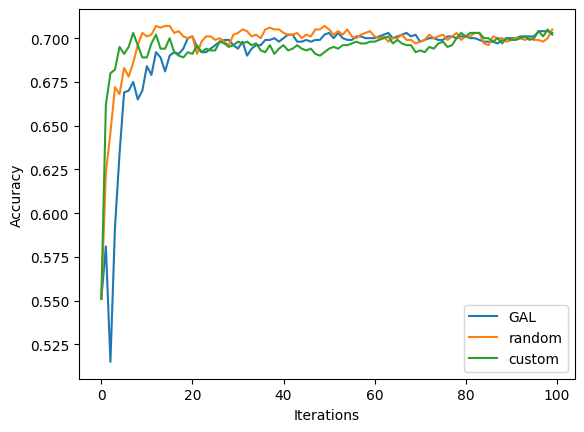

In [22]:
plt.plot(res_gal['aggr'], label='GAL')
if al.use_gnn:
	plt.plot(res_gal['GNN'], label='GNN', alpha=.5)
	plt.plot(res_gal['LR'], label='LR', alpha=.5)

for criterion, accuracy_scores in accuracy_scores_dict.items():
	plt.plot(accuracy_scores, label=criterion)
	# plt.plot(range(1, len(accuracy_scores) + 1), accuracy_scores, label=criterion)

plt.xlabel('Iterations')
plt.ylabel('Accuracy')
# plt.xticks(range(1, len(accuracy_scores) + 1))
plt.legend()
plt.show()
